# Машинное обучение, DS-поток
## Задание 1.1


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Теоретические задачи необходимо оформить в LaTeX/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.
* При решении без доказательства можно пользоваться любыми теоретическими свойствами, которые были на лекциях или семинарах.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

**Баллы за задание**
* Задача 1 &mdash; 2 балла
* Задача 2 &mdash; 2 балла
* Задача 3 &mdash; 12 баллов
* Задача 4 &mdash; 3 балла

## Задача 1.

Докажите, что критерий Джини равен вероятности ошибки случайного классификатора, который выдаёт предсказания с вероятностями пропорционально доле классов в выборке. 

## Задача 2.

Пусть $X = (x_1, ..., x_n)$ &mdash; выборка объектов и $Y = (Y_1, ..., Y_n)$ &mdash; соответствующие значения вещественного отклика. Критерий информативности для набора объектов вычисляется на основе того, насколько хорошо их отклик предсказывается константой:

$$
H(X) = \min_{c \in Y} \dfrac{1}{n} \sum_{i=1}^n L(Y_i, c),
$$

где $L(y, c)$ &mdash; некоторая функция потерь. Соответственно, чтобы получить вид критерия при конкретной функции потерь, необходимо аналитически найти оптимальное значение константы и подставить его в формулу для $H(X)$.

Выведите критерии информативности для следующих функций потерь:
1. $L(y, c) = (y-c)^2$;
2. $L(y, c) = |y-c|$.

Найдите также оптимальное предсказание в листьях дерева.

## Задача 3.

In [314]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо знать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** $Q(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$

**Реализация критериев информативности.**


Вспомните еще раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ:** критерий информативности должен показывать разброс ответов и должен быть тем меньше, чем меньше H(X). Критерий информативности должен минимизировать функцию потерь, выбирая оптимальную константу.


Перед тем, как непосредственно работать с решающими деревьями, реализуйте функции подсчёта значения критериев разбиения вершин решающих деревьев. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy` — массив размерности `(n,)` из значений отклика.

In [13]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    
    return np.var(y)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    
    return np.mean(np.abs(y - np.median(y)))


def get_probs_by_y(y, k=0):
    ''' Возвращает вектор частот для каждого класса выборки. '''

    return np.bincount(y, minlength=k) / len(y)

def get_nonzero_probs_by_y(y, k=0):
    ''' Возвращает вектор ненулевых частот для каждого класса выборки. '''

    return np.unique(y, return_counts=True)[1] / len(y)


def gini_criterion(y):
    ''' Критерий Джини. '''
    
    probs = get_probs_by_y(y)
    return np.sum(probs * (1 - probs))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    
    probs = get_nonzero_probs_by_y(y)
    return -np.sum(probs * np.log(probs))

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [14]:
assert np.allclose(get_nonzero_probs_by_y([1, 1, 2, 2, 7]), np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_nonzero_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

In [15]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализавать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс** `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


* `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,
* `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение критерия информативности,
* `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс** `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них. При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

* `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс** `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

* `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

* `predict` — получение предсказаний для всех элементов выборки.


**Класс** `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.
* `predict_proba_instance` — предсказание распределения вероятностей по классам для одного элемента выборки, 
* `predict_proba` — предсказание распределения вероятностей по классам для всех элементов выборки,
* `predict` — предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** для каждого из признаков будем перебирать только те значения, которые принимает данный признак на элементах выборки. Другие значения не имеет смысла перебирать, так как все равно дерево делится на левую и правую половину в зависимости от значений признака на элементах выборки, и нам без разницы, например, делить по $X_{(k)}$ или по $\frac{X_{(k - 1)} + X_{(k)}}{2}.$

**Структура решающего дерева**


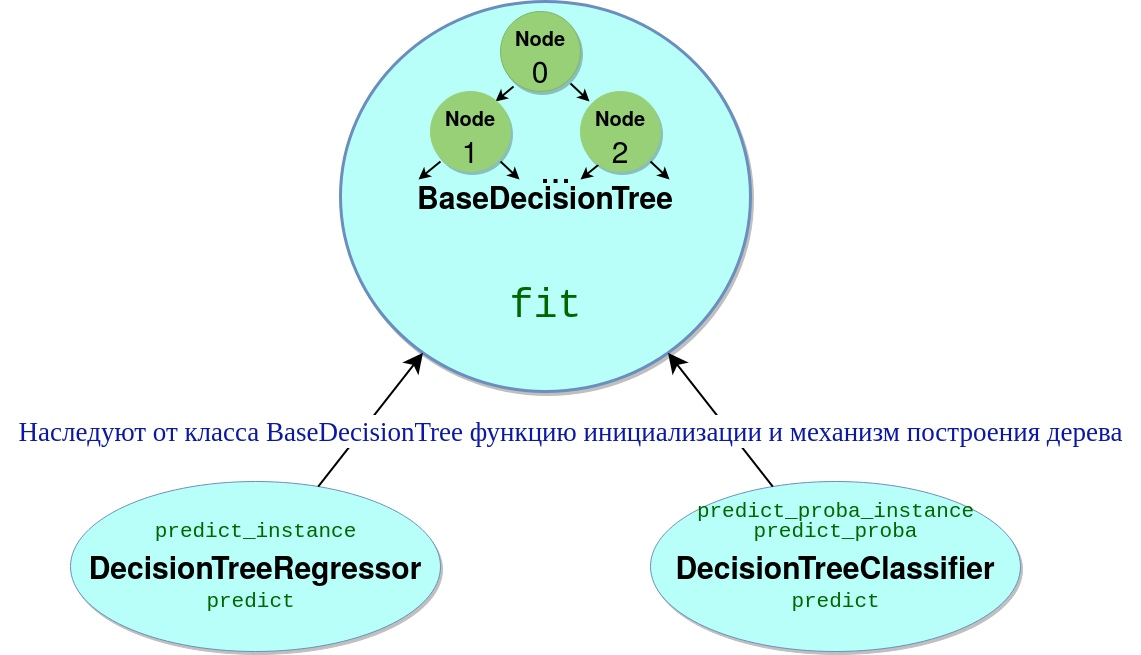

In [175]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[~np.isnan(arr)]


class Node(object):
    def __init__(self, split_feature=None, split_threshold=None, parent_criterion_value=np.inf):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        3) parent_criterion_value — значение критерия у родителя
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        
        # Значение критерия родителя. Нужно для критерия остановки по неубыванию значения критерия
        self.parent_criterion_value = parent_criterion_value

        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None

        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0

        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self, criterion, max_depth=np.inf, min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]

        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1

        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета
        # (они будут нашими порогами).
        self.feature_values = None
    
    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        
        if depth == self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) <= 1:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                y_l = y[X[:, feature_id] < threshold]
                y_r = y[X[:, feature_id] >= threshold]
                sample_size_l = len(y_l)
                sample_size_r = len(y_r)
                criterion_value = sample_size_l / sample_size * self.criterion(y_l) +\
                                  sample_size_r / sample_size * self.criterion(y_r)
                if criterion_value < best_criterion_value:
                    best_feature = feature_id
                    best_threshold = threshold
                    best_criterion_value = criterion_value
        
        # критерий остановки по неубыванию значения критерия
        if best_criterion_value >= self.nodes[v].parent_criterion_value:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
            
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        # разделим выборку на 2 части по порогу
        X_l = X[X[:, best_feature] < best_threshold]
        X_r = X[X[:, best_feature] >= best_threshold]
        y_l = y[X[:, best_feature] < best_threshold]
        y_r = y[X[:, best_feature] >= best_threshold]
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node(parent_criterion_value=best_criterion_value))
        self.nodes.append(Node(parent_criterion_value=best_criterion_value))
        
        # сохраняем индексы созданных вершин в качестве 
        # левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son =\
            len(self.nodes)-2, len(self.nodes)-1

        # рекурсивно строим дерево для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y — обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого из 
        # признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, "set_class_count", None)

        # если строится дерево для классификации, 
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — классы `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации — распределение вероятностей, а для регрессии — число $y$.

In [304]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        # если вершина — лист, возвращаем в качестве предсказания 
        # среднее всех элементов, содержащихся в ней
        if self.nodes[v].left_son == None:
            return self.nodes[v].y_values
            
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
            
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            return self.nodes[v].left_prob * left_predict + self.nodes[v].right_prob * right_predict
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [305]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y — значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        if self.nodes[v].left_son == None:
            # считаем долю каждого класса и возвращаем вектор вероятностей
            return get_probs_by_y(self.nodes[v].y_values, self.class_count)
            
        # если у объекта x значение признака по которому
        # происходит разделение, меньше порогового, 
        # то спускаемся в левое поддерево, иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
            
        # а если у объекта отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_proba_instance(
                x, self.nodes[v].left_son)
            right_predict = self.predict_proba_instance(
                x, self.nodes[v].right_son)
            return self.nodes[v].left_prob * left_predict + self.nodes[v].right_prob * right_predict
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X — выборка, для которой требуется получить вектор предсказаний y
        '''
        
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется получить
        вектор предсказаний y
        '''
        return np.argmax(self.predict_proba(X), axis=1)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте писать выводы.

**1. Задача классификации.**

Теперь самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [222]:
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)

Далее для критерия Джини и энтропийного критерия найдем оптимальные параметры обучения дерева — `max_depth` и `min_samples_split`.

In [223]:
classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['giny', 'entropy']

С начала надо разбить выборку на train и test.

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [225]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    classifier = DecisionTreeClassifier(criterion=criterion)
    classifier.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, classifier.predict(X_test))
    print(f'criterion: {criterion_name}, accuracy: {accuracy}')
    assert(accuracy >= 0.85, "Something is wrong with your classifier")

criterion: giny, accuracy: 0.9333333333333333
criterion: entropy, accuracy: 0.8888888888888888


**Построение графиков.**

Постройте графики зависимости accuracy от максимальной глубины дерева на обучающей и тестовой выборке для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 1 до 14. Значение `min_samples_split` фиксируйте.

In [315]:
def get_train_and_test_score(param_name, grid, criterion=gini_criterion,
                               best_params={'max_depth': 2, 'min_samples_split': 1}, estimator=DecisionTreeClassifier,
                             score=accuracy_score):
    '''
    Функция для оценки точности классификации
    для заданных значений параметра param_name
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) criterion - критерий,
    4) best_params - лучшие параметры, найденные поиском по сетке,
    5) estimator - оценивающий класс (классификационное или регрессионное дерево),
    6) score - метрика (r2 или accuracy)
    '''
    train_sc, test_sc = [], []
    for param_value in tqdm(grid):
        cur_params = best_params
        cur_params[param_name] = param_value
        est = estimator(criterion=criterion, **cur_params)
        est.fit(X_train, y_train)
        train_sc.append(score(y_train, est.predict(X_train)))
        test_sc.append(score(y_test, est.predict(X_test)))
    return train_sc, test_sc

In [316]:
def plot_dependence(param_name, grid=range(1, 14), title='', criteria=[gini_criterion, entropy_criterion], 
                    criterion_names=['giny', 'entropy'], best_params={'max_depth': 2, 'min_samples_split': 1},
                    estimator=DecisionTreeClassifier, score=accuracy_score):
    '''
    Функция для отображения графика зависимости accuracy
    от значения параметра c названием param_name
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика,
    4) classification_criteria - критерии,
    5) criterion_names - названия критериев,
    6) best_params - лучшие параметры, найденные поиском по сетке,
    7) estimator - оценивающий класс (классификационное или регрессионное дерево),
    8) score - метрика (r2 или accuracy)
    '''
    for criterion, criterion_name in zip(criteria, criterion_names):
        plt.figure(figsize=(12, 6))
        train_sc, test_sc = get_train_and_test_score(param_name, grid, criterion, best_params, estimator, score)
        plt.plot(grid, train_sc, label='train', lw=3)
        plt.plot(grid, test_sc, label='test', lw=3)
        plt.legend(fontsize=14)
        plt.xlabel(param_name)
        plt.ylabel('Score')
        cur_title = title + criterion_name
        plt.title(cur_title, fontsize=20)
        plt.show()

In [228]:
tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=gini_criterion),
    param_grid={'max_depth': np.arange(2, 7),
                'min_samples_split': [1, 2, 5, 10]},
    scoring=accuracy_score, 
)

In [229]:
tree_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(criterion=<function gini_criterion at 0x0000021B11F86DC0>),
             param_grid={'max_depth': array([2, 3, 4, 5, 6]),
                         'min_samples_split': [1, 2, 5, 10]},
             scoring=<function accuracy_score at 0x0000021B0FEF7700>)

In [231]:
print(tree_gridsearch.best_params_)

{'max_depth': 2, 'min_samples_split': 1}


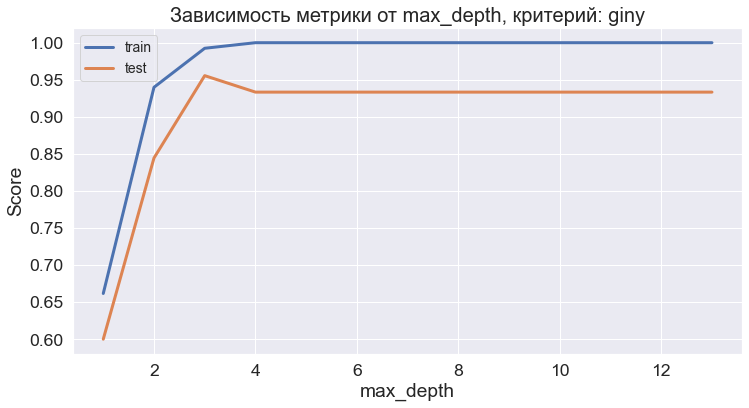

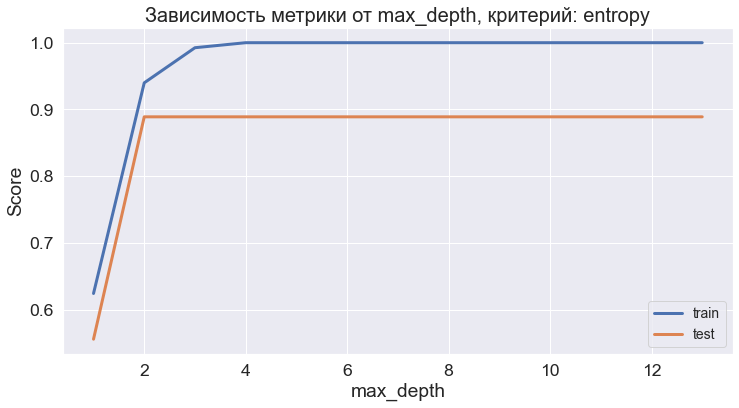

In [212]:
plot_dependence('max_depth', range(1, 14), title='Зависимость метрики от max_depth, критерий: ')

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод:** сначала мы проверили работу класса при дефолтных параметрах. Оказалось, что без ограничений по глубине и минимальному размеру разбиения дерево уже показывает результаты в районе 0.9 (чуть лучше себя показал критерий Джини). Далее, подобрав оптимальные гиперпараметры, мы построили графики метрики `accuracy` от гиперпараметра `max_depth`. Стоит отметить, что при увеличении `max_depth` метрика на трейне монотонно неубывает, что логично, так как мы сильнее подстраиваемся под тренировочную выборку. Однако на тесте в первом случае мы нашли некоторый оптимум, где метрика была где-то 0.95 на глубине 3, а далее метрика чуть-чуть упала. Это говорит о небольшом переобучении уже на глубине 4, из чего можно сделать вывод, что классификационное дерево быстро переобучается.

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите r2_score. Рассмотрим диапозон значений для `max_depth`: от 3 до 14.

In [268]:
from sklearn.datasets import load_boston

boston_X, boston_y = load_boston(return_X_y=True)

In [170]:
regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['MSE', 'MAE']

Разобьём выборку на обучение и тест.

In [171]:
X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, random_state=42)

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

In [172]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    regressor = DecisionTreeRegressor(criterion=criterion)
    regressor.fit(X_train, y_train)
    r2 = r2_score(y_test, regressor.predict(X_test))
    print(f'criterion: {criterion_name}, r2: {r2}')
    assert(r2 >= 0.5, "Something is wrong with your classifier")

criterion: MSE, r2: 0.7267894958242627
criterion: MAE, r2: 0.6650963760759343


In [190]:
tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeRegressor(criterion=mean_square_criterion),
    param_grid={'max_depth': np.arange(3, 10),
                'min_samples_split': [1, 2, 5, 10]},
    scoring="neg_mean_squared_error",
    verbose=2
)

In [191]:
tree_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END ...................max_depth=3, min_samples_split=1; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=1; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=1; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=1; total time=   0.6s
[CV] END ...................max_depth=3, min_samples_split=1; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.5s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.5s
[CV] END ...................max_depth=3, min_sa

[CV] END ...................max_depth=8, min_samples_split=1; total time=   8.0s
[CV] END ...................max_depth=8, min_samples_split=1; total time=   9.3s
[CV] END ...................max_depth=8, min_samples_split=1; total time=   8.0s
[CV] END ...................max_depth=8, min_samples_split=1; total time=  10.8s
[CV] END ...................max_depth=8, min_samples_split=2; total time=   6.3s
[CV] END ...................max_depth=8, min_samples_split=2; total time=   8.1s
[CV] END ...................max_depth=8, min_samples_split=2; total time=   9.3s
[CV] END ...................max_depth=8, min_samples_split=2; total time=   7.9s
[CV] END ...................max_depth=8, min_samples_split=2; total time=  10.7s
[CV] END ...................max_depth=8, min_samples_split=5; total time=   4.8s
[CV] END ...................max_depth=8, min_samples_split=5; total time=   5.3s
[CV] END ...................max_depth=8, min_samples_split=5; total time=   6.3s
[CV] END ...................

GridSearchCV(estimator=DecisionTreeRegressor(criterion=<function mean_square_criterion at 0x0000021B11F86310>),
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [1, 2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=2)

In [192]:
print(tree_gridsearch.best_params_)

{'max_depth': 6, 'min_samples_split': 10}


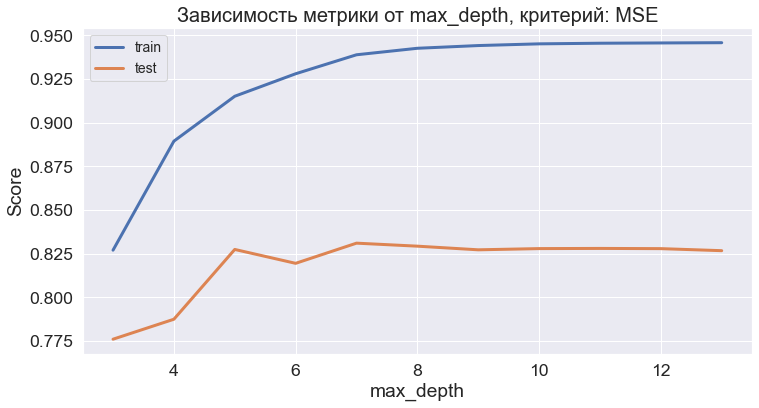

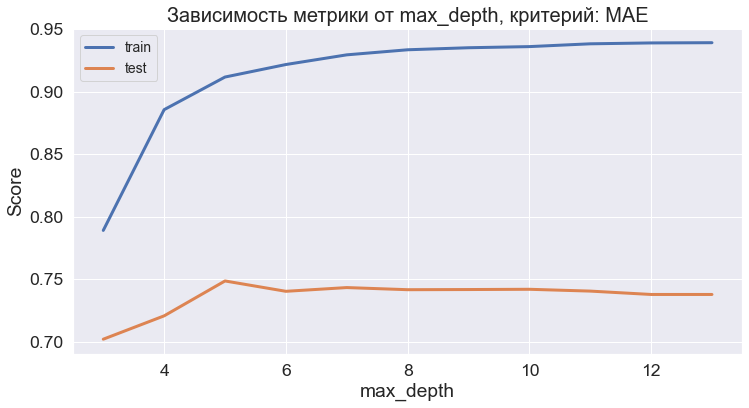

In [199]:
plot_dependence('max_depth', range(3, 14), criteria=[mean_square_criterion, mean_abs_criterion], 
                criterion_names=['MSE', 'MAE'], title='Зависимость метрики от max_depth, критерий: ',
                best_params={'max_depth': 6, 'min_samples_split': 10}, estimator=DecisionTreeRegressor,
               score=r2_score)

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод:** сначала мы проверили работу класса при дефолтных параметрах. Оказалось, что без ограничений по глубине и минимальному размеру разбиения дерево уже показывает результаты в районе 0.7 (чуть лучше себя показал `MSE`). Далее, подобрав оптимальные гиперпараметры, мы построили графики метрики `r2_score` от гиперпараметра `max_depth`. Стоит отметить, что при увеличении `max_depth` метрика на трейне монотонно неубывает, что логично, так как мы сильнее подстраиваемся под тренировочную выборку. Однако на тесте в случае `MSE` мы нашли 2 оптимальных значения, где метрика была где-то 0.83 на глубине 3 и 5, а далее метрика чуть-чуть упала. В случае `MAE` оптимум 0.75 находился на глубине 3. Это говорит о небольшом переобучении уже на небольших глубинах, из чего можно сделать вывод, что и регрессионное дерево быстро переобучается.

Действительно, дерево строится довольно медленно, особенно регрессионное. Я думаю, можно ускорить его построение с помощью ускорения поиска оптимальной пары признак, критическое значение. Ускорить можно с помощью некоторого предподсчета, а именно, сортировки по каждому признаку, которая помогла бы нам выделять левую и правую часть не за линию от размера выборки в родителе, а за логарифм. Также, мне кажется, можно ускорить нахождение оптимального разбиения, тратя, не O(nd), а O(n) времени. Для этого надо опять же отсортировать объекты по всем признакам и динамикой идти по отсортированным массивам, поддерживая нужную статистику (для `MSE`, например, достаточно поддерживать выборочную дисперсию и среднее значения).

## Задача 4.

В этой задаче вам предстоит освоиться с обработкой пропусков в решающих деревьях, реализованной ранее.

Рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [269]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 'education2', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 10000 строк данных.

In [270]:
adult_df = pd.read_csv('adult.data', header=None)[:10000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

,age,workclass,fnlwgt,education1,education2,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [216]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

,age,fnlwgt,education2,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [217]:
all_indices = np.arange(adult_df.shape[0])

for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = all_indices[adult_df[f'{feature}_ ?'] == 1]
        
        for dummy_feature in adult_df.columns:
            if not dummy_feature.startswith(f'{feature}_ '):
                continue
            if dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = None
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [218]:
np.sum(adult_df.isnull(), axis=0)

age                                  0
fnlwgt                               0
education2                           0
capital-gain                         0
capital-loss                         0
                                  ... 
native-country_ Thailand           181
native-country_ Trinadad&Tobago    181
native-country_ United-States      181
native-country_ Vietnam            181
native-country_ Yugoslavia         181
Length: 104, dtype: int64

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [235]:
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    adult_df, target, random_state=777
)
np.array(y_adult_train)

array([False,  True,  True, ..., False, False, False])

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения деревьев для классификации.

In [297]:
tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=gini_criterion),
    param_grid={'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20, 50],
                'min_samples_split': [1, 2, 5, 10, 50, 100, 500, 1000]},
    scoring='accuracy', verbose=5, error_score="raise"
)

In [298]:
tree_gridsearch.fit(X_adult_train.to_numpy(), y_adult_train.to_numpy())

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END ..max_depth=1, min_samples_split=1;, score=0.767 total time=   0.4s
[CV 2/5] END ..max_depth=1, min_samples_split=1;, score=0.755 total time=   0.4s
[CV 3/5] END ..max_depth=1, min_samples_split=1;, score=0.771 total time=   0.4s
[CV 4/5] END ..max_depth=1, min_samples_split=1;, score=0.752 total time=   0.4s
[CV 5/5] END ..max_depth=1, min_samples_split=1;, score=0.769 total time=   0.4s
[CV 1/5] END ..max_depth=1, min_samples_split=2;, score=0.767 total time=   0.4s
[CV 2/5] END ..max_depth=1, min_samples_split=2;, score=0.755 total time=   0.4s
[CV 3/5] END ..max_depth=1, min_samples_split=2;, score=0.771 total time=   0.4s
[CV 4/5] END ..max_depth=1, min_samples_split=2;, score=0.752 total time=   0.4s
[CV 5/5] END ..max_depth=1, min_samples_split=2;, score=0.769 total time=   0.4s
[CV 1/5] END ..max_depth=1, min_samples_split=5;, score=0.767 total time=   0.4s
[CV 2/5] END ..max_depth=1, min_samples_split=5

[CV 2/5] END .max_depth=3, min_samples_split=50;, score=0.759 total time=   1.5s
[CV 3/5] END .max_depth=3, min_samples_split=50;, score=0.783 total time=   1.5s
[CV 4/5] END .max_depth=3, min_samples_split=50;, score=0.764 total time=   1.6s
[CV 5/5] END .max_depth=3, min_samples_split=50;, score=0.776 total time=   1.5s
[CV 1/5] END max_depth=3, min_samples_split=100;, score=0.775 total time=   1.4s
[CV 2/5] END max_depth=3, min_samples_split=100;, score=0.759 total time=   1.4s
[CV 3/5] END max_depth=3, min_samples_split=100;, score=0.783 total time=   1.4s
[CV 4/5] END max_depth=3, min_samples_split=100;, score=0.764 total time=   1.4s
[CV 5/5] END max_depth=3, min_samples_split=100;, score=0.776 total time=   1.4s
[CV 1/5] END max_depth=3, min_samples_split=500;, score=0.775 total time=   1.4s
[CV 2/5] END max_depth=3, min_samples_split=500;, score=0.759 total time=   1.4s
[CV 3/5] END max_depth=3, min_samples_split=500;, score=0.783 total time=   1.4s
[CV 4/5] END max_depth=3, mi

[CV 3/5] END ..max_depth=7, min_samples_split=1;, score=0.784 total time=   3.1s
[CV 4/5] END ..max_depth=7, min_samples_split=1;, score=0.764 total time=   3.3s
[CV 5/5] END ..max_depth=7, min_samples_split=1;, score=0.776 total time=   3.2s
[CV 1/5] END ..max_depth=7, min_samples_split=2;, score=0.775 total time=   3.2s
[CV 2/5] END ..max_depth=7, min_samples_split=2;, score=0.761 total time=   3.3s
[CV 3/5] END ..max_depth=7, min_samples_split=2;, score=0.784 total time=   3.1s
[CV 4/5] END ..max_depth=7, min_samples_split=2;, score=0.764 total time=   3.3s
[CV 5/5] END ..max_depth=7, min_samples_split=2;, score=0.776 total time=   3.2s
[CV 1/5] END ..max_depth=7, min_samples_split=5;, score=0.775 total time=   3.2s
[CV 2/5] END ..max_depth=7, min_samples_split=5;, score=0.761 total time=   3.3s
[CV 3/5] END ..max_depth=7, min_samples_split=5;, score=0.784 total time=   3.1s
[CV 4/5] END ..max_depth=7, min_samples_split=5;, score=0.764 total time=   3.3s
[CV 5/5] END ..max_depth=7, 

[CV 4/5] END max_depth=15, min_samples_split=50;, score=0.764 total time=   3.6s
[CV 5/5] END max_depth=15, min_samples_split=50;, score=0.776 total time=   4.1s
[CV 1/5] END max_depth=15, min_samples_split=100;, score=0.775 total time=   5.1s
[CV 2/5] END max_depth=15, min_samples_split=100;, score=0.759 total time=   5.1s
[CV 3/5] END max_depth=15, min_samples_split=100;, score=0.784 total time=   3.8s
[CV 4/5] END max_depth=15, min_samples_split=100;, score=0.764 total time=   3.4s
[CV 5/5] END max_depth=15, min_samples_split=100;, score=0.776 total time=   4.0s
[CV 1/5] END max_depth=15, min_samples_split=500;, score=0.775 total time=   4.3s
[CV 2/5] END max_depth=15, min_samples_split=500;, score=0.759 total time=   4.4s
[CV 3/5] END max_depth=15, min_samples_split=500;, score=0.784 total time=   3.5s
[CV 4/5] END max_depth=15, min_samples_split=500;, score=0.764 total time=   3.3s
[CV 5/5] END max_depth=15, min_samples_split=500;, score=0.776 total time=   3.4s
[CV 1/5] END max_d

GridSearchCV(error_score='raise',
             estimator=DecisionTreeClassifier(criterion=<function gini_criterion at 0x0000021B11F86DC0>),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20, 50],
                         'min_samples_split': [1, 2, 5, 10, 50, 100, 500,
                                               1000]},
             scoring='accuracy', verbose=5)

In [299]:
tree_gridsearch.best_params_

{'max_depth': 2, 'min_samples_split': 1}

In [319]:
tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=entropy_criterion),
    param_grid={'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20, 50],
                'min_samples_split': [1, 2, 5, 10, 50, 100, 500, 1000]},
    scoring='accuracy', verbose=5, error_score="raise"
)

In [320]:
tree_gridsearch.fit(X_adult_train.to_numpy(), y_adult_train.to_numpy())

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END ..max_depth=1, min_samples_split=1;, score=0.767 total time=   0.9s
[CV 2/5] END ..max_depth=1, min_samples_split=1;, score=0.755 total time=   0.9s
[CV 3/5] END ..max_depth=1, min_samples_split=1;, score=0.771 total time=   0.9s
[CV 4/5] END ..max_depth=1, min_samples_split=1;, score=0.752 total time=   0.9s
[CV 5/5] END ..max_depth=1, min_samples_split=1;, score=0.769 total time=   0.9s
[CV 1/5] END ..max_depth=1, min_samples_split=2;, score=0.767 total time=   0.9s
[CV 2/5] END ..max_depth=1, min_samples_split=2;, score=0.755 total time=   0.9s
[CV 3/5] END ..max_depth=1, min_samples_split=2;, score=0.771 total time=   0.9s
[CV 4/5] END ..max_depth=1, min_samples_split=2;, score=0.752 total time=   0.9s
[CV 5/5] END ..max_depth=1, min_samples_split=2;, score=0.769 total time=   0.9s
[CV 1/5] END ..max_depth=1, min_samples_split=5;, score=0.767 total time=   0.9s
[CV 2/5] END ..max_depth=1, min_samples_split=5

[CV 2/5] END .max_depth=3, min_samples_split=50;, score=0.763 total time=   3.1s
[CV 3/5] END .max_depth=3, min_samples_split=50;, score=0.783 total time=   3.1s
[CV 4/5] END .max_depth=3, min_samples_split=50;, score=0.764 total time=   3.1s
[CV 5/5] END .max_depth=3, min_samples_split=50;, score=0.777 total time=   3.1s
[CV 1/5] END max_depth=3, min_samples_split=100;, score=0.775 total time=   2.7s
[CV 2/5] END max_depth=3, min_samples_split=100;, score=0.763 total time=   2.7s
[CV 3/5] END max_depth=3, min_samples_split=100;, score=0.783 total time=   2.7s
[CV 4/5] END max_depth=3, min_samples_split=100;, score=0.764 total time=   2.7s
[CV 5/5] END max_depth=3, min_samples_split=100;, score=0.777 total time=   2.7s
[CV 1/5] END max_depth=3, min_samples_split=500;, score=0.775 total time=   2.7s
[CV 2/5] END max_depth=3, min_samples_split=500;, score=0.763 total time=   2.7s
[CV 3/5] END max_depth=3, min_samples_split=500;, score=0.783 total time=   2.7s
[CV 4/5] END max_depth=3, mi

[CV 3/5] END ..max_depth=7, min_samples_split=1;, score=0.783 total time=   6.1s
[CV 4/5] END ..max_depth=7, min_samples_split=1;, score=0.764 total time=   6.1s
[CV 5/5] END ..max_depth=7, min_samples_split=1;, score=0.777 total time=   6.4s
[CV 1/5] END ..max_depth=7, min_samples_split=2;, score=0.775 total time=   6.1s
[CV 2/5] END ..max_depth=7, min_samples_split=2;, score=0.763 total time=   5.2s
[CV 3/5] END ..max_depth=7, min_samples_split=2;, score=0.783 total time=   6.1s
[CV 4/5] END ..max_depth=7, min_samples_split=2;, score=0.764 total time=   6.1s
[CV 5/5] END ..max_depth=7, min_samples_split=2;, score=0.777 total time=   6.4s
[CV 1/5] END ..max_depth=7, min_samples_split=5;, score=0.775 total time=   6.1s
[CV 2/5] END ..max_depth=7, min_samples_split=5;, score=0.763 total time=   5.2s
[CV 3/5] END ..max_depth=7, min_samples_split=5;, score=0.783 total time=   6.1s
[CV 4/5] END ..max_depth=7, min_samples_split=5;, score=0.764 total time=   6.1s
[CV 5/5] END ..max_depth=7, 

[CV 4/5] END max_depth=15, min_samples_split=50;, score=0.764 total time=   6.6s
[CV 5/5] END max_depth=15, min_samples_split=50;, score=0.777 total time=   5.7s
[CV 1/5] END max_depth=15, min_samples_split=100;, score=0.775 total time=   5.8s
[CV 2/5] END max_depth=15, min_samples_split=100;, score=0.763 total time=   4.9s
[CV 3/5] END max_depth=15, min_samples_split=100;, score=0.783 total time=   5.7s
[CV 4/5] END max_depth=15, min_samples_split=100;, score=0.764 total time=   6.2s
[CV 5/5] END max_depth=15, min_samples_split=100;, score=0.777 total time=   5.4s
[CV 1/5] END max_depth=15, min_samples_split=500;, score=0.775 total time=   5.4s
[CV 2/5] END max_depth=15, min_samples_split=500;, score=0.763 total time=   4.5s
[CV 3/5] END max_depth=15, min_samples_split=500;, score=0.783 total time=   5.4s
[CV 4/5] END max_depth=15, min_samples_split=500;, score=0.764 total time=   5.8s
[CV 5/5] END max_depth=15, min_samples_split=500;, score=0.777 total time=   5.4s
[CV 1/5] END max_d

GridSearchCV(error_score='raise',
             estimator=DecisionTreeClassifier(criterion=<function entropy_criterion at 0x0000021B11F86550>),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20, 50],
                         'min_samples_split': [1, 2, 5, 10, 50, 100, 500,
                                               1000]},
             scoring='accuracy', verbose=5)

In [321]:
tree_gridsearch.best_params_

{'max_depth': 3, 'min_samples_split': 1}

Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

In [317]:
X_train = X_adult_train.to_numpy()
y_train = y_adult_train.to_numpy()
X_test = X_adult_test.to_numpy()
y_test = y_adult_test.to_numpy()

100%|██████████| 19/19 [01:37<00:00,  5.13s/it]


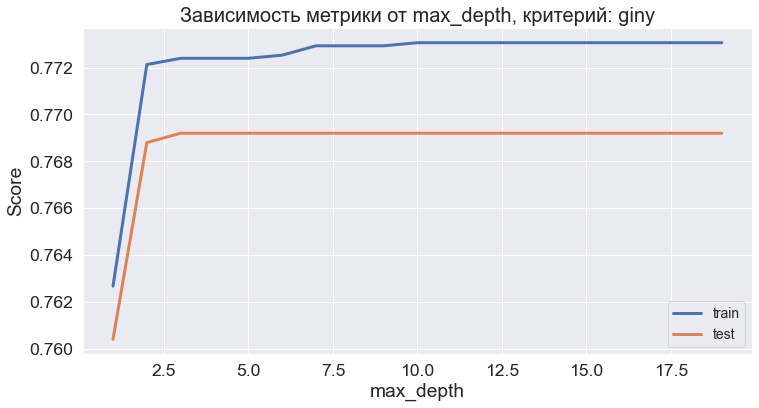

100%|██████████| 19/19 [02:22<00:00,  7.52s/it]


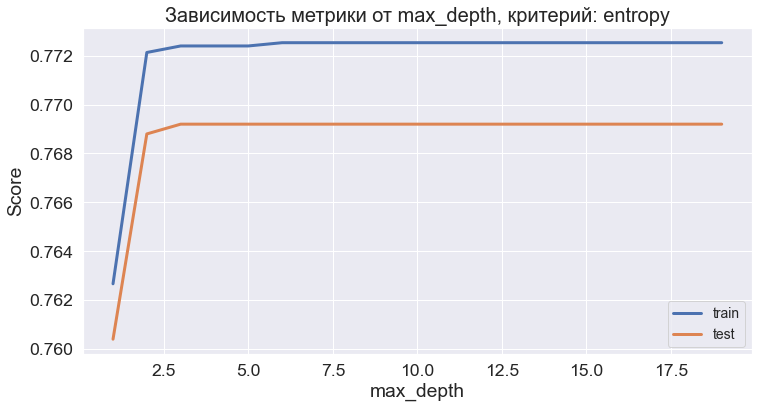

In [318]:
plot_dependence('max_depth', range(1, 20), title='Зависимость метрики от max_depth, критерий: ')

**Вывод:** подобрав оптимальные гиперпараметры, мы построили графики метрики `accuracy` от гиперпараметра `max_depth`. Интересно, что оптимальным параметром `GridSearchCV` считает глубину 2, хотя и метрики отличаются совсем незначительно. Это может говорить о том, что классы довольно сильно смешаны, то есть, сложно разделимы критериями $x^j < t.$ Стоит отметить, что при увеличении `max_depth` метрика на трейне монотонно неубывает, что логично, так как мы сильнее подстраиваемся под тренировочную выборку. Однако на тесте при обоих критериях мы нашли некоторый оптимум, где метрика была где-то 0.77 на глубине 3, а далее метрика монотонна. Это говорит о том, что даже на больших данных дерево быстро переобучается. 